In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import matplotlib_venn as venn
import altair as alt
import geopandas as gpd

In [2]:
# read in data for enslaved people tab
enslaved_tab = pd.read_csv('Census Charlestown 1775 05-14-24 - Enslaved people.csv')

# clean up formatting
enslaved_tab.columns = ['Year of Record', 'Total People Enslaved in Record', '# Male', '# Female', '# Black', 
                        '# Native', 'Name and/or Description', 'Enslaver Last Name', 'Enslaver First Name', 
                        'Town', 'Unique ID']
enslaved_tab = enslaved_tab.drop([0])

# convert some columns from nan to 0
enslaved_tab['# Male'] = enslaved_tab['# Male'].fillna(0)
enslaved_tab['# Female'] = enslaved_tab['# Female'].fillna(0)
enslaved_tab['# Native'] = enslaved_tab['# Native'].fillna(0)

# convert datatypes
enslaved_tab['Year of Record'] = enslaved_tab['Year of Record'].astype(int)
enslaved_tab['Total People Enslaved in Record'] = enslaved_tab['Total People Enslaved in Record'].astype(int)
enslaved_tab['# Male'] = enslaved_tab['# Male'].astype(int)
enslaved_tab['# Female'] = enslaved_tab['# Female'].astype(int)
enslaved_tab['# Black'] = enslaved_tab['# Black'].astype(int)
enslaved_tab['# Native'] = enslaved_tab['# Native'].astype(int)

def gender(person):
    if person['# Female'] > 0:
        return 'Female'
    elif person['# Male'] > 0:
        return 'Male'
    else:
        return 'Unknown'

# Add a new column indicating if the person is male or female
enslaved_tab['Gender'] = enslaved_tab.apply(gender, axis=1)

enslaved_tab

,Year of Record,Total People Enslaved in Record,# Male,# Female,# Black,# Native,Name and/or Description,Enslaver Last Name,Enslaver First Name,Town,Unique ID,Gender
1,1741,1,0,1,1,0,Coelia,Alford,Captain,Charlestown,ID_1,Female
2,1751,1,0,1,1,0,Phillis,Alford,John,Charlestown,ID_2,Female
3,1756,1,1,0,1,0,Cerado,"Alford, Esqr.",John,Charlestown,ID_3,Male
4,1753,1,0,1,1,0,Rose,Angier,R,Charlestown,ID_4,Female
5,1749,1,0,1,1,0,Belinda,Austin,John,Charlestown,ID_5,Female
...,...,...,...,...,...,...,...,...,...,...,...,...
158,1730,1,0,1,1,0,Pippwe,NaN,NaN,Charlestown,ID_158,Female
159,1760,1,1,0,1,0,Pomp Miller,NaN,NaN,Charlestown,ID_159,Male
160,1753,1,1,0,1,0,Prince Green,NaN,NaN,Charlestown,ID_160,Male
161,1706,1,1,0,1,0,Robert Comings,NaN,NaN,Charlestown,ID_161,Male


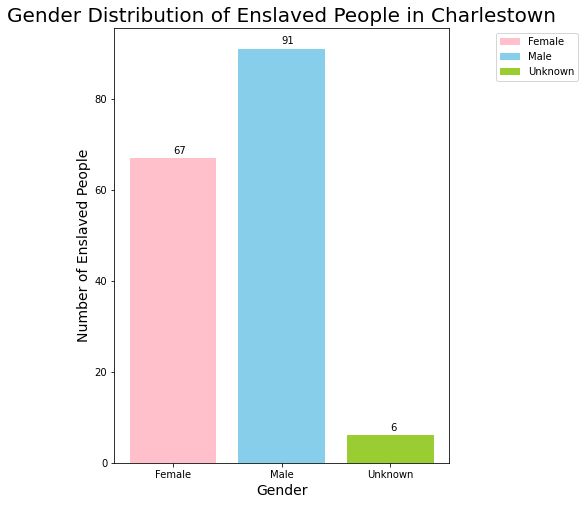

In [3]:
# get counts of male and female
female_count = enslaved_tab['# Female'].sum()
male_count = enslaved_tab['# Male'].sum()
total_count = enslaved_tab['Total People Enslaved in Record'].sum()
unknown_count = total_count - (female_count + male_count)

# make bar chart for gender distribution
plt.figure(figsize=(6, 8))
plt.bar('Female', female_count, color='pink', label='Female')
plt.bar('Male', male_count, color='skyblue', label='Male')
plt.bar('Unknown', unknown_count, color='yellowgreen', label='Unknown')
plt.title('Gender Distribution of Enslaved People in Charlestown', fontsize=20)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Number of Enslaved People', fontsize=14)
plt.text(0, 68, female_count)
plt.text(1, 92, male_count)
plt.text(2, 7, unknown_count)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.legend(bbox_to_anchor=(1.4, 1))
plt.show()

/var/folders/yg/vlskscg174zgkdtq09c25czr0000gn/T/ipykernel_35762/3400796750.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  census_tab = pd.read_csv('Census Charlestown 1775 05-14-24 - Census.csv')


Text(0.5, 1.0, 'Consistency of Enslaved People Listed Across Datasets')

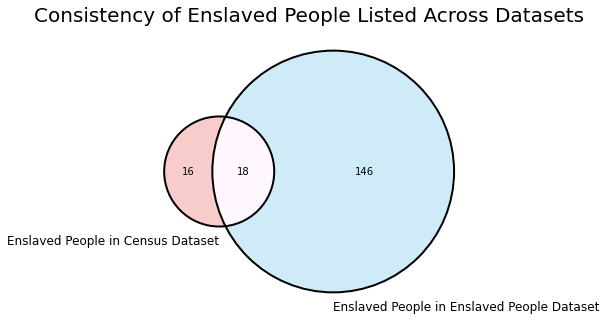

In [4]:
# read in data for census tab
census_tab = pd.read_csv('Census Charlestown 1775 05-14-24 - Census.csv')
census_tab.columns = ['Order', 'Family', 'Original Order', 'Link to Claim', 'Last Name', 'Maiden Name', 
                      'First Name', 'Relation to Head of Household', 'Age', 'Sex', 'Race', 'Occupation', 
                      'Household Inventory #', '1375 People', 'Household', 'Family Notes', 'Unique ID', 
                      'Family V2', 'Household V2']
census_tab = census_tab.drop(0)

# filter for only people who are not white and enslaved
census_race_b_m = census_tab.loc[census_tab['Race'] != 'W']
census_enslaved = census_race_b_m.loc[(census_race_b_m['Relation to Head of Household'] == 'Enslaved') | 
                                      (census_race_b_m['Relation to Head of Household'] == 'enslaved')]

# get counts of enslaved people from census tab and enslaved tab
census_enslaved_count = census_enslaved['Order'].count()
enslaved_tab_count = enslaved_tab['Total People Enslaved in Record'].sum()

# look for overlap in tabs based on unique ID
overlap_people = []
overlap_count = 0
census_id_lst = census_enslaved['Unique ID'].to_list()

# iterate through the people in the enslaved tab
for i in range(len(enslaved_tab['Unique ID'])):
    
    # if match is found, note their name and update counts
    if enslaved_tab['Unique ID'].iloc[i] in census_id_lst:
        overlap_people.append(enslaved_tab['Name and/or Description'].iloc[i])
        overlap_count += 1
        census_enslaved_count -= 1
        enslaved_tab_count -= 1

# make venn diagram showing consistency across tabs
plt.figure(figsize=(6, 8))
venn.venn2(subsets=(census_enslaved_count, enslaved_tab_count, overlap_count), 
      set_labels=('Enslaved People in Census Dataset', 'Enslaved People in Enslaved People Dataset'), 
      set_colors=('lightcoral', 'skyblue'))
venn.venn2_circles(subsets=(census_enslaved_count, enslaved_tab_count, overlap_count))
plt.title('Consistency of Enslaved People Listed Across Datasets', fontsize=20)

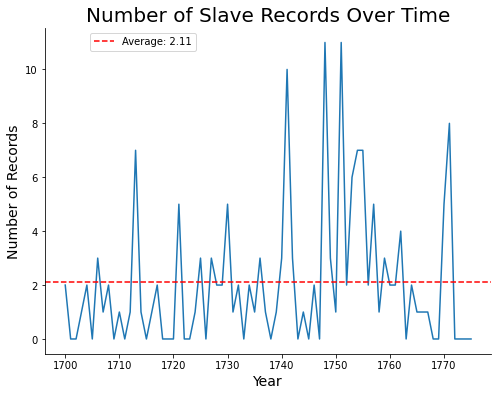

In [5]:
# collect number of records per year
record_year_dict = {}
for i in range(len(enslaved_tab['Year of Record'])):
    if enslaved_tab['Year of Record'].iloc[i] in record_year_dict.keys():
        record_year_dict[enslaved_tab['Year of Record'].iloc[i]] += 1
    else:
        record_year_dict[enslaved_tab['Year of Record'].iloc[i]] = 1
        
# add 0 to years which are not listed in data
year_range = [i for i in range(1700, 1776)]
for i in year_range:
    if i not in record_year_dict.keys():
        record_year_dict[i] = 0
        
# convert dictionary to list of tuples sorted by year
record_year_lst = [(key, value) for key, value in record_year_dict.items()]
record_year_lst.sort(key=lambda tup: tup[0])

# make separate lists for x and y
years = []
num_records = []
for year in record_year_lst:
    
    # do not include records after 1775
    if year[0] > 1775:
        break
        
    years.append(year[0])
    num_records.append(year[1])
    
# plot number of records over time
plt.figure(figsize=(8, 6))
plt.plot(years, num_records)
plt.title('Number of Slave Records Over Time', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Records', fontsize=14)

# add average line
record_year_avg = sum(num_records) / len(num_records)
plt.axhline(y=record_year_avg, color='red', linestyle='--', label=f'Average: {round(record_year_avg, 2)}')

plt.legend(bbox_to_anchor=(0.35, 1))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.show()

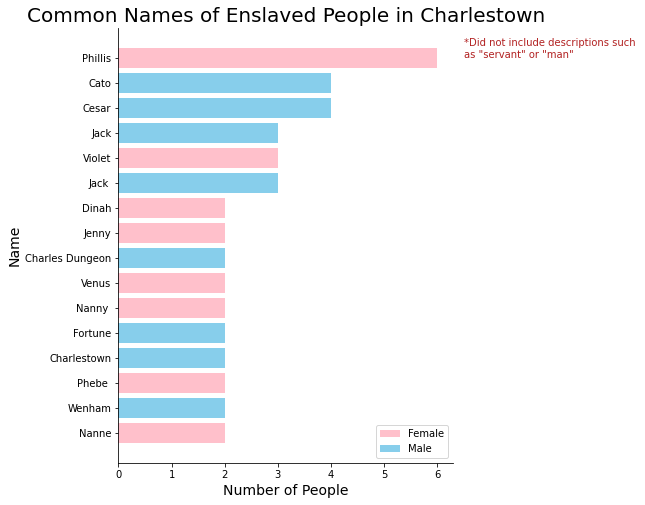

In [6]:
# get number of common names 
# count first time attached to ID to make sure we are not double counting the same person
names_id_dict = {}
for i in range(len(enslaved_tab['Name and/or Description'])):
    name_id = enslaved_tab['Name and/or Description'].iloc[i] + '_' + enslaved_tab['Unique ID'].iloc[i] + '_' + enslaved_tab['Gender'].iloc[i]
    if name_id in names_id_dict.keys():
        names_id_dict[name_id] += 1
    else:
        names_id_dict[name_id] = 1
        
# count second time after distinct people have been identified
names_dict = {}
for key in names_id_dict.keys():
    name_gender = key.split('_')[0] + '_' + key.split('_')[3]
    if name_gender in names_dict.keys():
        names_dict[name_gender] += 1
    else:
        names_dict[name_gender] = 1
        
# make list of names that appear more than once
common_names = []
for key, value in names_dict.items():
    if value > 1:
        common_names.append((key, value))
        
# sort the list from greatest to least
common_names.sort(key=lambda tup: tup[1])

# create color dictionary
gender_colors = {'Female': 'pink', 'Male': 'skyblue', 'Unknown': 'lightgreen'}

# plot most common names 
plt.figure(figsize=(6, 8))

for name in common_names:
    
    # do not include descriptions
    if name[0].split('_')[0] == 'servant' or name[0].split('_')[0] == 'man':
        pass
    
    else:
        if name[0].split('_')[0] == 'Nanne' or name[0].split('_')[0] == 'Wenham':
            plt.barh(name[0].split('_')[0], name[1], color=gender_colors[name[0].split('_')[1]], 
                     label=name[0].split('_')[1])
        else:
            plt.barh(name[0].split('_')[0], name[1], color=gender_colors[name[0].split('_')[1]])
        
plt.title('Common Names of Enslaved People in Charlestown', fontsize=20)
plt.xlabel('Number of People', fontsize=14)
plt.ylabel('Name', fontsize=14)
plt.legend()
plt.text(6.5, 15, f'*Did not include descriptions such \nas "servant" or "man"', color='firebrick')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.show()

Text(0.5, 1.0, 'Occupations of Black People in 1775 Charlestown Census')

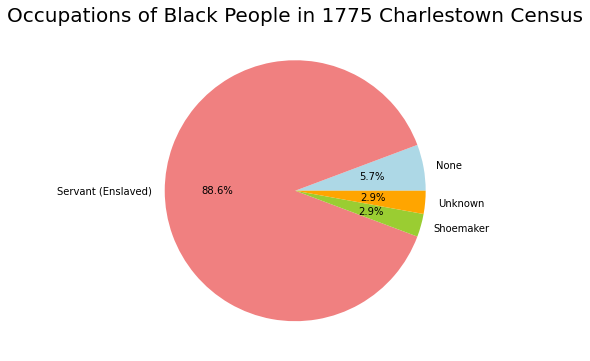

In [7]:
# show occupation of black people in census tab

# make dictionary to get occupation counts
census_race_b = census_race_b_m.loc[census_race_b_m['Race'] == 'B']
occupations = {'None': 2}

for i in range(len(census_race_b['First Name'])):
    
    # identify people who were free
    if census_race_b['Relation to Head of Household'].iloc[i] != 'Enslaved' and census_race_b['Relation to Head of Household'].iloc[i] != 'enslaved':
        if census_race_b['Occupation'].iloc[i] == 'Enslaved?':
            occupations['Unknown'] = 1
        elif census_race_b['Occupation'].iloc[i] == 'Shoemaker':
            occupations[census_race_b['Occupation'].iloc[i]] = 1
    
    # get counts of slaves/servants
    elif census_race_b['Occupation'].iloc[i] == 'servant' or census_race_b['Occupation'].iloc[i] == 'Servant':
        if 'Servant (Enslaved)' in occupations.keys():
            occupations['Servant (Enslaved)'] += 1
        else:
            occupations['Servant (Enslaved)'] = 1
        
# make a pie chart showing data
fig, ax = plt.subplots(figsize=(8, 6))
_, _, autotexts = ax.pie(occupations.values(), labels=occupations.keys(), 
                         colors=['lightblue', 'lightcoral', 'yellowgreen', 'orange'], autopct='%1.1f%%')
plt.title('Occupations of Black People in 1775 Charlestown Census', fontsize=20)

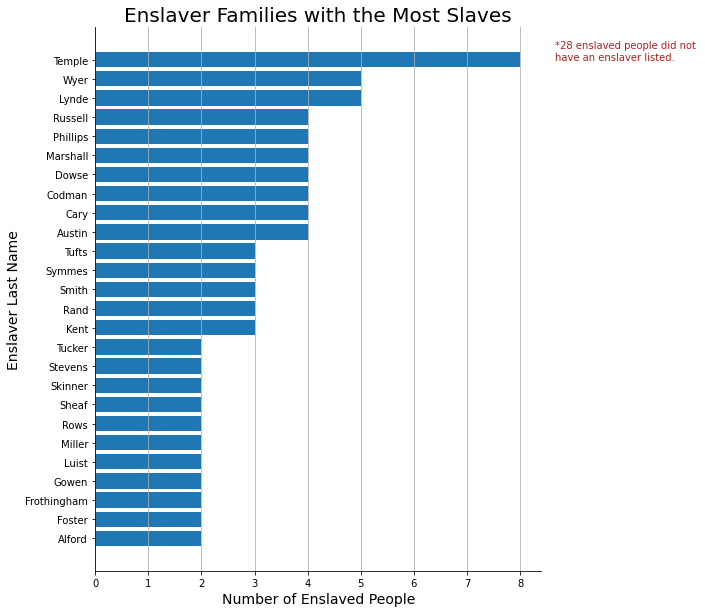

In [8]:
# get number of enslaved people by enslaver family
enslaver_names_dict = {}
for i in range(len(enslaved_tab['Enslaver Last Name'])):
    if enslaved_tab['Enslaver Last Name'].iloc[i] in enslaver_names_dict.keys():
        enslaver_names_dict[enslaved_tab['Enslaver Last Name'].iloc[i]] += 1
    else:
        enslaver_names_dict[enslaved_tab['Enslaver Last Name'].iloc[i]] = 1
        
# make list of enslaver families that enslaved more than one person
enslaver_names_lst = []
for key, value in enslaver_names_dict.items():
    if value > 1:
        enslaver_names_lst.append((key, value))
        
# sort the list from greatest to least
enslaver_names_lst.sort(key=lambda tup: tup[1])

# make separate lists for x and y
enslaver_names_x = []
enslaver_names_y = []
for name in enslaver_names_lst:
    
    # skip nan values
    if enslaver_names_lst.index(name) == 26:
        pass
    
    else:
        enslaver_names_x.append(name[0])
        enslaver_names_y.append(name[1])
        
# plot the data
plt.figure(figsize=(8, 10))
plt.barh(enslaver_names_x, enslaver_names_y)
plt.title('Enslaver Families with the Most Slaves', fontsize=20)
plt.xlabel('Number of Enslaved People', fontsize=14)
plt.ylabel('Enslaver Last Name', fontsize=14)
plt.text(8.65, 25, '*28 enslaved people did not \nhave an enslaver listed.', color='firebrick')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.grid(True, axis='x')
plt.rc('axes', axisbelow=False)
plt.show()

In [9]:
# filter data for just families with more than one slave
multi_slaves_lst = []

for i in range(len(enslaved_tab['Enslaver Last Name'])):
    if enslaved_tab['Enslaver Last Name'].iloc[i] in enslaver_names_x:
        multi_slaves_lst.append(enslaved_tab.iloc[i])
        
multi_slaves = pd.DataFrame(multi_slaves_lst, columns=['Year of Record', 'Total People Enslaved in Record', 
                                                       '# Male', '# Female', '# Black', '# Native', 
                                                       'Name and/or Description', 'Enslaver Last Name', 
                                                       'Enslaver First Name', 'Town', 'Unique ID'])

def gender(person):
    if person['# Female'] > 0:
        return 'Female'
    elif person['# Male'] > 0:
        return 'Male'
    else:
        return 'Unknown'

# Add a new column indicating if the person is male or female
multi_slaves['Gender'] = multi_slaves.apply(gender, axis=1)

In [10]:
# base chart to build on top of
base = (
    alt.Chart(data=multi_slaves)
    .transform_aggregate(count_="count()", groupby=["Enslaver Last Name", "Enslaver First Name"])
    .transform_stack(
        stack="count_",
        as_=["stack_count_Enslaver_Last_Name1", "stack_count_Enslaver_Last_Name2"],
        offset="normalize",
        sort=[alt.SortField("Enslaver Last Name", "ascending")],
        groupby=[],
    )
    .transform_window(
        x="min(stack_count_Enslaver_Last_Name1)",
        x2="max(stack_count_Enslaver_Last_Name2)",
        rank_First="dense_rank()",
        distinct_First="distinct(Enslaver First Name)",
        groupby=["Enslaver Last Name"],
        frame=[None, None],
        sort=[alt.SortField("Enslaver First Name", "ascending")],
    )
    .transform_window(
        rank_Last="dense_rank()",
        frame=[None, None],
        sort=[alt.SortField("Enslaver Last Name", "ascending")],
    )
    .transform_stack(
        stack="count_",
        groupby=["Enslaver Last Name"],
        as_=["y", "y2"],
        offset="normalize",
        sort=[alt.SortField("Enslaver First Name", "ascending")],
    )
    .transform_calculate(
        ny="datum.y + (datum.rank_First - 1) * datum.distinct_First * 0.01 / 3",
        ny2="datum.y2 + (datum.rank_First - 1) * datum.distinct_First * 0.01 / 3",
        nx="datum.x + (datum.rank_Last - 1) * 0.01",
        nx2="datum.x2 + (datum.rank_Last - 1) * 0.01",
        xc="(datum.nx+datum.nx2)/2",
        yc="(datum.ny+datum.ny2)/2",
    ).properties(
        height=300,
        width=2000
    )
)

# get geometry for rectangles
rect = base.mark_rect().encode(
    x=alt.X("nx:Q").axis(None),
    x2="nx2",
    y=alt.Y("ny:Q").axis(None),
    y2="ny2",
    color=alt.Color("Enslaver Last Name:N").legend(None),
    opacity=alt.Opacity("Enslaver First Name:N").legend(None),
    tooltip=["Enslaver Last Name:N", "Enslaver First Name:N"],
)

# add labels to rectangles
text = base.mark_text(baseline="middle").encode(
    alt.X("xc:Q").axis(None),
    alt.Y("yc:Q").title("Enslaver First Name"),
    text="Enslaver First Name:N"
)

# combine to create mosaic
mosaic = rect + text

# add enslaver name labels
origin_labels = base.mark_text(baseline="middle", align="center").encode(
    alt.X("min(xc):Q").title("Enslaver Last Name").axis(orient="top", labelColor='white'),
    alt.Color("Enslaver Last Name").legend(None),
    text="Enslaver Last Name",
).properties(height=10, width=2000, title='Enslaver Families in 1775 Charlestown')

# combine chart together
mosaic_w_labels = (
    (origin_labels & mosaic)
    .resolve_scale(x="shared")
    .configure_view(stroke="")
    .configure_concat(spacing=1)
    .configure_axis(domain=False, ticks=False, labels=True, grid=False)
)

# create brush to link to other chart
brush = alt.selection_interval(empty=True)
mosaic_w_labels = mosaic_w_labels.add_params(brush)

# make gender chart connected by brush
family_bar = alt.Chart(data=multi_slaves, title='Gender of Enslaved People').transform_aggregate(count_="count()",
                                                              groupby=["Enslaver Last Name",
                                                                       "Enslaver First Name",
                                                                       "Name and/or Description",
                                                                      "Gender"]).transform_stack(
        stack="count_",
        as_=["stack_count_Enslaver_Last_Name1", "stack_count_Enslaver_Last_Name2"],
        offset="normalize",
        sort=[alt.SortField("Enslaver Last Name", "ascending")],
        groupby=[],
    ).transform_window(
        x="min(stack_count_Enslaver_Last_Name1)",
        x2="max(stack_count_Enslaver_Last_Name2)",
        rank_First="dense_rank()",
        distinct_First="distinct(Enslaver First Name)",
        groupby=["Enslaver Last Name"],
        frame=[None, None],
        sort=[alt.SortField("Enslaver First Name", "ascending")],
    ).transform_window(
        rank_Last="dense_rank()",
        frame=[None, None],
        sort=[alt.SortField("Enslaver Last Name", "ascending")],
    ).transform_stack(
        stack="count_",
        groupby=["Enslaver Last Name"],
        as_=["y", "y2"],
        offset="normalize",
        sort=[alt.SortField("Enslaver First Name", "ascending")],
    ).transform_calculate(
        ny="datum.y + (datum.rank_First - 1) * datum.distinct_First * 0.01 / 3",
        ny2="datum.y2 + (datum.rank_First - 1) * datum.distinct_First * 0.01 / 3",
        nx="datum.x + (datum.rank_Last - 1) * 0.01",
        nx2="datum.x2 + (datum.rank_Last - 1) * 0.01",
        xc="(datum.nx+datum.nx2)/2",
        yc="(datum.ny+datum.ny2)/2",
    ).mark_bar().encode(
    x=alt.X('Gender:N', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Name and/or Description:N', title='Name and/or Description'),
    color='Enslaver Last Name:N',
    tooltip=['Enslaver First Name', 'Enslaver Last Name']
).transform_filter(brush).properties(
        height=550,
        width=300
)

interactive_enslavers = ((mosaic_w_labels & family_bar).configure_concat(spacing=50).configure_axis(domain=False, ticks=False, labels=True, grid=False))
interactive_enslavers

alt.VConcatChart(...)

In [ ]:
# read in data
df_nb = gpd.read_file("1775Charlestown.geojson")

# from "Group 5 Census Charlestown 1775 05-14-24"
overlap = pd.read_csv('overlap.csv')

# clean data
df_overlap = overlap.drop(columns=["which tab"])
df_overlap.rename(columns={"Name": "Name of Enslaved Person"}, inplace=True)
df_overlap['Enslaver Name'] = df_overlap['Enslaver First Name'] + ' ' + df_overlap['Enslaver Last Name']
df_overlap['Sex'] = df_overlap['Sex'].replace({'?': 'Unknown'}).fillna('Unknown')
df_overlap['Sex'] = df_overlap['Sex'].replace({'M': 'Male'})
df_overlap['Sex'] = df_overlap['Sex'].replace({'F': 'Female'})

# count number of enslaved people and gender per family and make a new df for these counts
family_counts = df_overlap['Family'].value_counts().reset_index()
family_counts.columns = ['F1775_Clai', 'Count']
family_info = df_overlap[['Family', 'Enslaver Name']].drop_duplicates()
family_info = pd.merge(family_info, family_counts, left_on='Family', right_on='F1775_Clai', how='left')

gender_counts = df_overlap.groupby(['Family', 'Sex']).size().unstack(fill_value=0).reset_index()
gender_counts.columns = ['Family', 'Female', 'Male', 'Unknown']
family_info = pd.merge(family_info, gender_counts, on='Family', how='left')

family_info = family_info.dropna()
family_info['Count'] = family_info['Count'].astype(int)
family_info['Female'] = family_info['Female'].astype(int)
family_info['Male'] = family_info['Male'].astype(int)
family_info['Unknown'] = family_info['Unknown'].astype(int)

family_info.rename(columns={"Count": "Enslaved People Count"}, inplace=True)

# blank map of charlestown
res_map = alt.Chart(df_nb).mark_geoshape(
    fill = "#f5f5f5",
    stroke='#ccc'
).project(
    type='identity',
    reflectY=True
).properties(
    width=800,
    height=600
)

# color layer with color scale based on how many enslaved people

click = alt.selection_point(fields=['F1775_Clai'])

layer = alt.Chart(df_nb).mark_geoshape(
    stroke='black'
).encode(
    tooltip=[alt.Tooltip("Enslaved People Count:Q", title="Enslaved People"),
             alt.Tooltip("Enslaver Name:N", title="Enslaver Name"),
             alt.Tooltip("F1775_Clai:N", title="Family ID (1775)")],
    color=alt.condition(click,
        alt.Color("Enslaved People Count:Q", scale=alt.Scale(scheme='reds', reverse=True)),
        alt.value('lightgrey')),
    opacity=alt.condition(click, alt.value(1), alt.value(0.4)),
).transform_lookup(
    lookup='F1775_Clai',
    from_=alt.LookupData(family_info, 'F1775_Clai', ['F1775_Clai', 'Enslaved People Count', 'Enslaver Name' ])
).add_params(click
).project(
    type='identity',
    reflectY=True
).properties(
    width=800,
    height=600
)

gender_bars = alt.Chart(family_info).mark_bar().encode(
    y=alt.Y("Sex:N", title='Gender'),
    x=alt.X("Enslaved People Count:Q", title='Number of Enslaved People'),
    color=alt.Color("Sex:N", scale=alt.Scale(domain=['Female', 'Male', 'Unknown'], range=['pink', 'lightskyblue', 'darkseagreen']), legend=None),
    tooltip=[alt.Tooltip("Enslaved People Count:Q")]
).transform_filter(click
).transform_aggregate(
    Female='sum(Female)',
    Male='sum(Male)',
    Unknown='sum(Unknown)',
    groupby=[]
).transform_fold(['Female', 'Male', 'Unknown'], as_=['Sex', 'Enslaved People Count']
).properties(
    width=400,
    height=100
)

# note
note = alt.Chart(pd.DataFrame({'text': [
    'Note: This visualization is based solely on the data \n'
    'provided, where the slaveholder was identifiable and \n'
    'their household IDs matched the provided mapping data.']})
).mark_text(
    align="left",
    font='Helvetica',
    fontSize=12,
    color='grey',
    lineBreak='\n'
).encode(text='text'
)

layered_maps = res_map + layer
gender_and_note = gender_bars | note

final = (layered_maps & gender_and_note).properties(title='Geographic Distribution and Gender Demographics of Enslaved People in Charlestown'
).configure_title(
    fontSize=18,
    font='Helvetica',
    anchor='middle')

final